In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [99]:
import copy

In [5]:
import sklearn.preprocessing 

In [57]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS 

In [12]:
import sys

In [13]:
sys.path.append('/Users/spx8sk/work/git/PotFit')

In [2]:
!ls

001                                  gamma.png
alpha.png                            phi_21.png
amp_21.png                           phi_22.png
amp_22.png                           pre_processing
beta.png                             pytorch-sobolev.ipynb
compute_preprocessing.toml           run-gen-training.sh
data_generation_coprec_training.toml run-preproc.sh
data_generation_coprec_val.toml      training_data
data_logs                            validation_data
fit.toml


In [3]:
!ls training_data/

alpha.npy  amp_22.npy coords.npy phi_21.npy times.npy
amp_21.npy beta.npy   gamma.npy  phi_22.npy


In [8]:
times = np.load("training_data/times.npy")
times = times.reshape(-1,1)
beta = np.load("training_data/beta.npy")

In [58]:
def get_derivative(t, A):
    return np.array([IUS(t, a).derivative()(t) for a in A])

In [9]:
times_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 0))
times_scaled = times_scaler.fit_transform(times)

In [62]:
dbeta = get_derivative(times_scaled[:,0], beta)

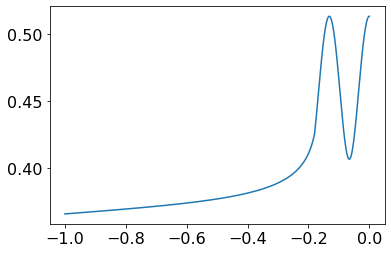

In [63]:
plt.figure()
plt.plot(times_scaled, beta[0])

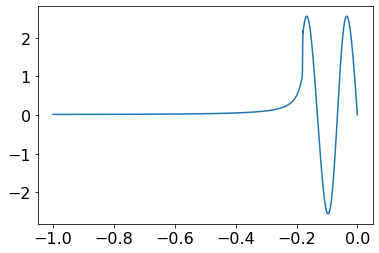

In [64]:
plt.figure()
plt.plot(times_scaled, dbeta[0])

In [166]:
X_train = times_scaled.copy()
y_train = beta[0].copy()[:,np.newaxis]
dy_train = dbeta[0].copy()[:,np.newaxis]

X_train=X_train[:-1]
y_train=y_train[:-1]
dy_train=dy_train[:-1]

In [167]:
X_train.shape

(1218, 1)

In [168]:
y_train.shape

(1218, 1)

In [169]:
dy_train.shape

(1218, 1)

In [170]:
# X_train = np.row_stack((X_train, X_train))
# y_train = y_train.ravel()[:,np.newaxis]
# dy_train = dy_train.ravel()[:,np.newaxis]

In [171]:
X_train.shape

(1218, 1)

In [172]:
y_train.shape

(1218, 1)

In [173]:
dy_train.shape

(1218, 1)

In [174]:
data = [X_train, y_train, dy_train]

# pytorch s2relu activation

In [175]:
# https://towardsdatascience.com/extending-pytorch-with-custom-activation-functions-2d8b065ef2fa

In [176]:
def srelu(input):
    return torch.relu(-(input-1)) * torch.relu(input)

def s2relu(input):
    '''
    '''
    return torch.sin(2*torch.tensor(np.pi)*input) * srelu(input)

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class S2RELU(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return s2relu(input)
    
class SRELU(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return srelu(input)

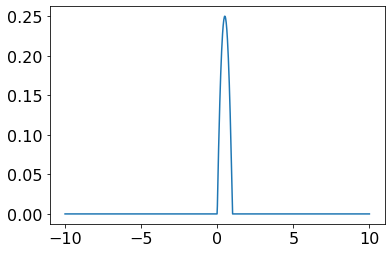

In [177]:
plt.plot(torch.linspace(-10, 10, 1000), SRELU().forward(torch.linspace(-10, 10, 1000)))

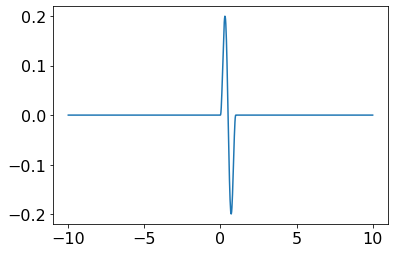

In [178]:
plt.plot(torch.linspace(-10, 10, 1000), S2RELU().forward(torch.linspace(-10, 10, 1000)))

# set up pytorch model

In [179]:
# device = torch.device('cuda')
device = torch.device('cpu')

In [375]:
device

device(type='cpu')

In [426]:
class Net(nn.Module):
    def __init__(self, activation, num_hidden_units=100, num_layers=1):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, num_hidden_units, bias=True)
        self.fc2 = nn.ModuleList()
        for i in range(num_layers):
            self.fc2.append(nn.Linear(num_hidden_units, num_hidden_units, bias=True))
        self.fc3 = nn.Linear(num_hidden_units, 1)
        self.activation = activation

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        for fc in self.fc2:
            x = fc(x)
            x = self.activation(x)
        x = self.fc3(x)
        return x

    def predict(self, x):
        self.eval()
        y = self(x)
        x = x.cpu().numpy().flatten()
        y = y.cpu().detach().numpy().flatten()
        return [x, y]

In [484]:
net = Net(activation=S2RELU(), num_hidden_units=128, num_layers=2).to(device)
# net = Net(activation=torch.nn.ReLU(), num_hidden_units=128, num_layers=2).to(device)

In [485]:
print(net)

Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (activation): S2RELU()
)


In [486]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

In [487]:
lam1 = 1.0/25


In [488]:
num_data = len(data[0])

In [489]:
pred_freq = 1000
num_batches = 2

In [490]:
num_epochs = 500

In [491]:
print_freq = 100

In [492]:
losses = []

In [493]:
%%time
best_loss = np.inf
for epoch in range(num_epochs):
    indices = np.arange(num_data)
    np.random.shuffle(indices)
    epoch_mse0 = 0.0
    epoch_mse1 = 0.0
    for batch in np.split(indices, num_batches):
        input = torch.tensor(data[0][batch], dtype=torch.float32, device=device).unsqueeze(1)
        target0 = torch.tensor(data[1][batch], dtype=torch.float32, device=device).unsqueeze(1)
        target1 = torch.tensor(data[2][batch], dtype=torch.float32, device=device).unsqueeze(1)

        net.eval()
        input.requires_grad = True

        output0 = net(input)
        output0.sum().backward(retain_graph=True, create_graph=True)
        output1 = input.grad
        input.requires_grad = False

        net.train()

        mse0 = criterion(output0, target0)
        mse1 = criterion(output1, target1)

        epoch_mse0 += mse0.item() * len(batch)
        epoch_mse1 += mse1.item() * len(batch)

        loss = mse0 + lam1 * mse1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_mse0 /= num_data
    epoch_mse1 /= num_data
    epoch_loss = epoch_mse0+lam1*epoch_mse1
    losses.append(epoch_loss)
    if ((epoch+1) % print_freq) == 0: 
        print('epoch', epoch,
              'lr', '{:.7f}'.format(optimizer.param_groups[0]['lr']),
              'mse0', '{:.9f}'.format(epoch_mse0),
              'mse1', '{:.9f}'.format(epoch_mse1),
              'loss', '{:.9f}'.format(epoch_loss))
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        state = copy.deepcopy(net.state_dict())

epoch 99 lr 0.0010000 mse0 0.000287798 mse1 0.584597290 loss 0.023671690
epoch 199 lr 0.0010000 mse0 0.000002578 mse1 0.022623084 loss 0.000907502
epoch 299 lr 0.0010000 mse0 0.000001493 mse1 0.017513262 loss 0.000702024
epoch 399 lr 0.0010000 mse0 0.000001148 mse1 0.013972285 loss 0.000560039
epoch 499 lr 0.0010000 mse0 0.000000904 mse1 0.011166174 loss 0.000447551
CPU times: user 31.8 s, sys: 9.51 s, total: 41.3 s
Wall time: 30.7 s


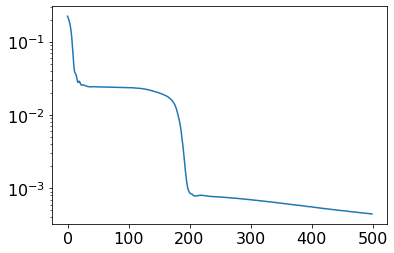

In [494]:
plt.figure()
plt.plot(losses)
plt.yscale('log')

In [495]:
print('Best score:', best_loss)

Best score: 0.0004470217516814046


In [496]:
net.load_state_dict(state)

<All keys matched successfully>

In [497]:
X_train

array([[-1.00000000e+00],
       [-9.99178982e-01],
       [-9.98357964e-01],
       ...,
       [-2.46305419e-03],
       [-1.64203612e-03],
       [-8.21018062e-04]])

In [498]:
torch.tensor(X_train)

tensor([[-1.0000e+00],
        [-9.9918e-01],
        [-9.9836e-01],
        ...,
        [-2.4631e-03],
        [-1.6420e-03],
        [-8.2102e-04]], dtype=torch.float64)

In [499]:
net = net.float()

In [500]:
yhat = net.predict(torch.tensor(times_scaled).float())

In [501]:
yhat

[array([-1.0000000e+00, -9.9917901e-01, -9.9835795e-01, ...,
        -1.6420361e-03, -8.2101807e-04,  0.0000000e+00], dtype=float32),
 array([0.36487287, 0.36491847, 0.36496317, ..., 0.5170632 , 0.51797736,
        0.51885897], dtype=float32)]

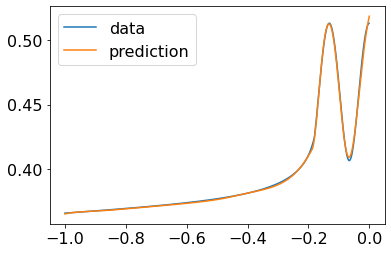

In [502]:
plt.figure()
plt.plot(X_train, y_train, label='data')
plt.plot(yhat[0], yhat[1], label='prediction')
plt.legend()

# function and comparison

In [507]:
def run_fit(net, data, num_epochs = 500, print_freq = 100, use_deriv=True):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)
    lam1 = 1.0/25
    num_data = len(data[0])
    pred_freq = 1000
    num_batches = 2
    losses = []
    
    best_loss = np.inf
    for epoch in range(num_epochs):
        indices = np.arange(num_data)
        np.random.shuffle(indices)
        epoch_mse0 = 0.0
        epoch_mse1 = 0.0
        for batch in np.split(indices, num_batches):
            input = torch.tensor(data[0][batch], dtype=torch.float32, device=device).unsqueeze(1)
            target0 = torch.tensor(data[1][batch], dtype=torch.float32, device=device).unsqueeze(1)
            target1 = torch.tensor(data[2][batch], dtype=torch.float32, device=device).unsqueeze(1)

            net.eval()
            input.requires_grad = True

            output0 = net(input)
            output0.sum().backward(retain_graph=True, create_graph=True)
            output1 = input.grad
            input.requires_grad = False

            net.train()

            mse0 = criterion(output0, target0)
            mse1 = criterion(output1, target1)

            epoch_mse0 += mse0.item() * len(batch)
            epoch_mse1 += mse1.item() * len(batch)

            if use_deriv:
                loss = mse0 + lam1 * mse1
            else:
                loss = mse0

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        epoch_mse0 /= num_data
        epoch_mse1 /= num_data
        epoch_loss = epoch_mse0+lam1*epoch_mse1
        losses.append(epoch_loss)
        if ((epoch+1) % print_freq) == 0: 
            print('epoch', epoch,
                  'lr', '{:.7f}'.format(optimizer.param_groups[0]['lr']),
                  'mse0', '{:.9f}'.format(epoch_mse0),
                  'mse1', '{:.9f}'.format(epoch_mse1),
                  'loss', '{:.9f}'.format(epoch_loss))
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            state = copy.deepcopy(net.state_dict())
            
    net.load_state_dict(state)
    net = net.float()
    return net, losses

In [517]:

# net = Net(activation=torch.nn.ReLU(), num_hidden_units=128, num_layers=2).to(device)

In [519]:
%%time
net = Net(activation=S2RELU(), num_hidden_units=128, num_layers=2).to(device)
net_1, losses_1 = run_fit(net, data, num_epochs = 500, print_freq = 100, use_deriv=True)

epoch 99 lr 0.0010000 mse0 0.000000119 mse1 0.002214405 loss 0.000088695
epoch 199 lr 0.0010000 mse0 0.000000460 mse1 0.001264543 loss 0.000051042
epoch 299 lr 0.0010000 mse0 0.000000366 mse1 0.000946550 loss 0.000038228
epoch 399 lr 0.0010000 mse0 0.000000245 mse1 0.000825041 loss 0.000033247
epoch 499 lr 0.0010000 mse0 0.000000211 mse1 0.000946240 loss 0.000038061
CPU times: user 42.5 s, sys: 11.4 s, total: 53.9 s
Wall time: 40.2 s


In [520]:
%%time
net = Net(activation=S2RELU(), num_hidden_units=128, num_layers=2).to(device)
net_2, losses_2 = run_fit(net, data, num_epochs = 500, print_freq = 100, use_deriv=False)

epoch 99 lr 0.0010000 mse0 0.000228526 mse1 0.507494330 loss 0.020528299
epoch 199 lr 0.0010000 mse0 0.000001071 mse1 0.008148274 loss 0.000327002
epoch 299 lr 0.0010000 mse0 0.000000659 mse1 0.007758119 loss 0.000310984
epoch 399 lr 0.0010000 mse0 0.000000573 mse1 0.007375630 loss 0.000295598
epoch 499 lr 0.0010000 mse0 0.000000543 mse1 0.006961772 loss 0.000279014
CPU times: user 30.4 s, sys: 9.95 s, total: 40.3 s
Wall time: 30.4 s


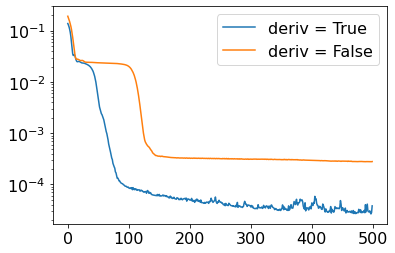

In [523]:
plt.figure()
plt.plot(losses_1, label='deriv = True')
plt.plot(losses_2, label='deriv = False')
plt.yscale('log')
plt.legend()

In [538]:
yhat_1 = net_1.predict(torch.tensor(data[0]).float())
yhat_2 = net_2.predict(torch.tensor(data[0]).float())

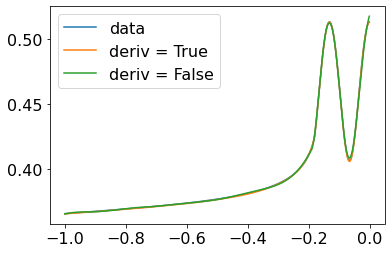

In [539]:
plt.figure()
plt.plot(X_train, y_train, label='data')
plt.plot(yhat_1[0], yhat_1[1], label='deriv = True')
plt.plot(yhat_2[0], yhat_2[1], label='deriv = False')
plt.legend()

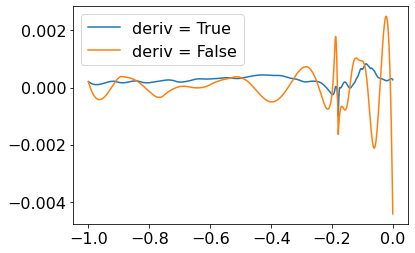

In [540]:
plt.figure()
plt.plot(data[0][:,0], data[1][:,0]-yhat_1[1], label='deriv = True')
plt.plot(data[0][:,0], data[1][:,0]-yhat_2[1], label='deriv = False')
plt.legend()